<a href="https://colab.research.google.com/github/taejoonlab/BloodSweatTears/blob/main/rnaseq/R-kallisto_tximport_limma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEG analysis of kallisto TPMs with limma

## Set up R in Google Colab
You can activate R in Google Colab by starting it with the following URL:
* https://colab.research.google.com/notebook#create=true&language=r 
* Or https://colab.to/r

Check out this webpage for more details. https://towardsdatascience.com/how-to-use-r-in-google-colab-b6e02d736497 

In [1]:
# Check the R version
package_version(R.version)

[1] ‘4.2.0’

## Install R packages

In [2]:
if (!require(readr)) install.packages('readr')
library(readr)

if (!require(ggplot2)) install.packages('ggplot2')
library(ggplot2)

if (!require(psych)) install.packages('psych')
library(psych)

Loading required package: readr

Loading required package: ggplot2

Loading required package: psych


Attaching package: ‘psych’


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha




## Install Bioconductor package

In [3]:
## for bioconductor package maintenance
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

## tximport: to import expression data
if (!require("tximport")) BiocManager::install("tximport")
library(tximport)

## edger: for DEGList function
if (!require("edgeR")) BiocManager::install("edgeR")
library(edgeR)

## limma: for DEG analysis
if (!require("limma")) BiocManager::install("limma")
library(limma)

Loading required package: tximport

Loading required package: edgeR

Loading required package: limma



In [4]:
sessionInfo()

R version 4.2.0 (2022-04-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] edgeR_3.38.1        limma_3.52.1        tximport_1.24.0    
[4] BiocManager_1.30.18 psych_2.2.5         ggplot2_3.3.6      
[7] readr_2.1.2        

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.8.3     pillar_1.7.0     compiler_4.2.0   base64enc_0.1-3 
 

## Download a tx2gene file & load it.

This file contains the table for a transcript-gene relationship. This file is used to perform a gene-level expression analysis (merging the expression of all transcripts into a gene) For GENCODE primary transcript file, you can download a pre-made version from the GitHub repo: https://github.com/taejoonlab/BloodSweatTears/blob/main/db/gencode.v40.transcripts.fa.gz.tx2gene

This file looks like below (first column should be matched to the header of FASTA file you used as a reference):
```
ENST00000456328.2|ENSG00000223972.5|OTTHUMG00000000961.2|OTTHUMT00000362751.1|DDX11L1-202|DDX11L1|1657|processed_transcript|    DDX11L1
ENST00000450305.2|ENSG00000223972.5|OTTHUMG00000000961.2|OTTHUMT00000002844.2|DDX11L1-201|DDX11L1|632|transcribed_unprocessed_pseudogene|       DDX11L1
ENST00000488147.1|ENSG00000227232.5|OTTHUMG00000000958.1|OTTHUMT00000002839.1|WASH7P-201|WASH7P|1351|unprocessed_pseudogene|    WASH7P
```

You can simply create this file from the downloaded, gzipped FASTA file using the following script: https://github.com/taejoonlab/BloodSweatTears/blob/main/db/fa_gz-to-tx2gene.sh



In [6]:
filename_tx2gene <- './gencode.v40.transcripts.fa.gz.tx2gene'
download.file("https://github.com/taejoonlab/BloodSweatTears/blob/main/db/gencode.v40.transcripts.fa.gz.tx2gene?raw=true", filename_tx2gene)

In [7]:
list.files()

[1] "blood.PRJNA782396_Zhang2022_covid19.conf.txt"           
 [2] "gencode.v40.transcripts.fa.gz.tx2gene"                  
 [3] "sample_data"                                            
 [4] "SRR16992513.gencode_v40_tx.kallisto_quant.abundance.tsv"
 [5] "SRR16992514.gencode_v40_tx.kallisto_quant.abundance.tsv"
 [6] "SRR16992515.gencode_v40_tx.kallisto_quant.abundance.tsv"
 [7] "SRR16992516.gencode_v40_tx.kallisto_quant.abundance.tsv"
 [8] "SRR16992517.gencode_v40_tx.kallisto_quant.abundance.tsv"
 [9] "SRR16992518.gencode_v40_tx.kallisto_quant.abundance.tsv"
[10] "SRR16992519.gencode_v40_tx.kallisto_quant.abundance.tsv"
[11] "SRR16992520.gencode_v40_tx.kallisto_quant.abundance.tsv"
[12] "SRR16992521.gencode_v40_tx.kallisto_quant.abundance.tsv"
[13] "SRR16992522.gencode_v40_tx.kallisto_quant.abundance.tsv"
[14] "SRR16992523.gencode_v40_tx.kallisto_quant.abundance.tsv"
[15] "SRR16992524.gencode_v40_tx.kallisto_quant.abundance.tsv"
[16] "SRR16992525.gencode_v40_tx.kallisto_quant.abundance.tsv"
[17] "SRR16992526.gencode_v40_tx.kallisto_quant.abundance.tsv"
[18] "SRR16992527.gencode_v40_tx.kallisto_quant.abundance.tsv"
[19] "SRR16992528.gencode_v40_tx.kallisto_quant.abundance.tsv"
[20] "SRR16992529.gencode_v40_tx.kallisto_quant.abundance.tsv"
[21] "SRR16992530.gencode_v40_tx.kallisto_quant.abundance.tsv"
[22] "SRR16992531.gencode_v40_tx.kallisto_quant.abundance.tsv"
[23] "SRR16992532.gencode_v40_tx.kallisto_quant.abundance.tsv"
[24] "SRR16992533.gencode_v40_tx.kallisto_quant.abundance.tsv"
[25] "SRR16992534.gencode_v40_tx.kallisto_quant.abundance.tsv"
[26] "SRR16992535.gencode_v40_tx.kallisto_quant.abundance.tsv"
[27] "SRR16992536.gencode_v40_tx.kallisto_quant.abundance.tsv"
[28] "SRR16992537.gencode_v40_tx.kallisto_quant.abundance.tsv"

In [8]:
tx2gene <- read_tsv(filename_tx2gene, col_names=FALSE)
colnames(tx2gene) <- c('txName', 'geneName')
head(tx2gene)

Rows: 246624 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): X1, X2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


txName,geneName
<chr>,<chr>
ENST00000456328.2|ENSG00000223972.5|OTTHUMG00000000961.2|OTTHUMT00000362751.1|DDX11L1-202|DDX11L1|1657|processed_transcript|,DDX11L1
ENST00000450305.2|ENSG00000223972.5|OTTHUMG00000000961.2|OTTHUMT00000002844.2|DDX11L1-201|DDX11L1|632|transcribed_unprocessed_pseudogene|,DDX11L1
ENST00000488147.1|ENSG00000227232.5|OTTHUMG00000000958.1|OTTHUMT00000002839.1|WASH7P-201|WASH7P|1351|unprocessed_pseudogene|,WASH7P
ENST00000619216.1|ENSG00000278267.1|-|-|MIR6859-1-201|MIR6859-1|68|miRNA|,MIR6859-1
ENST00000473358.1|ENSG00000243485.5|OTTHUMG00000000959.2|OTTHUMT00000002840.1|MIR1302-2HG-202|MIR1302-2HG|712|lncRNA|,MIR1302-2HG
ENST00000469289.1|ENSG00000243485.5|OTTHUMG00000000959.2|OTTHUMT00000002841.2|MIR1302-2HG-201|MIR1302-2HG|535|lncRNA|,MIR1302-2HG


## Upload kallisto output and a config file

A config file contains the information of filename, group_name, and sample_name. Following example is about four replicated samples (Vaccine3-1 to Vaccine3-4) in the same group (Vaccine3).
```
Filename	SampleName	GroupName
SRR16992513.gencode_v40_tx.kallisto_quant/abundance.tsv	Vaccine3-4	Vaccine3
SRR16992514.gencode_v40_tx.kallisto_quant/abundance.tsv	Vaccine3-3	Vaccine3
SRR16992515.gencode_v40_tx.kallisto_quant/abundance.tsv	Vaccine3-2	Vaccine3
SRR16992516.gencode_v40_tx.kallisto_quant/abundance.tsv	Vaccine3-1	Vaccine3
```
You can find the full list of PRJNA782396 files at the following link. 
https://pub.taejoonlab.org/BloodSweatTears/blood.PRJNA782396_Zhang2022_covid19/blood.PRJNA782396_Zhang2022_covid19.conf.txt

Also, I renamed a kallisto TSV files with the folder as below:
```
original: my_data/abundance.tsv
renamed:  my_data.abundance.tsv
```

In contrast to python, it is quite challenging to access the Google Drive. So I recommend to upload kallisto tsv files and "a config fie" through your browser. You can drag and drop to the colab filespace panel (if it is not shown, click 'the folder' icon as highlighted below).
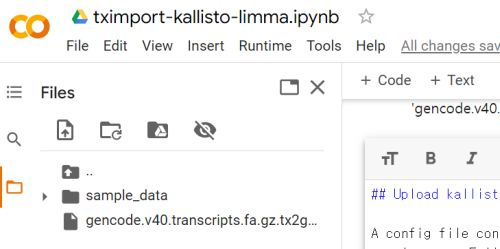

In [9]:
# Check the uploaded files
list.files()

[1] "blood.PRJNA782396_Zhang2022_covid19.conf.txt"           
 [2] "gencode.v40.transcripts.fa.gz.tx2gene"                  
 [3] "sample_data"                                            
 [4] "SRR16992513.gencode_v40_tx.kallisto_quant.abundance.tsv"
 [5] "SRR16992514.gencode_v40_tx.kallisto_quant.abundance.tsv"
 [6] "SRR16992515.gencode_v40_tx.kallisto_quant.abundance.tsv"
 [7] "SRR16992516.gencode_v40_tx.kallisto_quant.abundance.tsv"
 [8] "SRR16992517.gencode_v40_tx.kallisto_quant.abundance.tsv"
 [9] "SRR16992518.gencode_v40_tx.kallisto_quant.abundance.tsv"
[10] "SRR16992519.gencode_v40_tx.kallisto_quant.abundance.tsv"
[11] "SRR16992520.gencode_v40_tx.kallisto_quant.abundance.tsv"
[12] "SRR16992521.gencode_v40_tx.kallisto_quant.abundance.tsv"
[13] "SRR16992522.gencode_v40_tx.kallisto_quant.abundance.tsv"
[14] "SRR16992523.gencode_v40_tx.kallisto_quant.abundance.tsv"
[15] "SRR16992524.gencode_v40_tx.kallisto_quant.abundance.tsv"
[16] "SRR16992525.gencode_v40_tx.kallisto_quant.abundance.tsv"
[17] "SRR16992526.gencode_v40_tx.kallisto_quant.abundance.tsv"
[18] "SRR16992527.gencode_v40_tx.kallisto_quant.abundance.tsv"
[19] "SRR16992528.gencode_v40_tx.kallisto_quant.abundance.tsv"
[20] "SRR16992529.gencode_v40_tx.kallisto_quant.abundance.tsv"
[21] "SRR16992530.gencode_v40_tx.kallisto_quant.abundance.tsv"
[22] "SRR16992531.gencode_v40_tx.kallisto_quant.abundance.tsv"
[23] "SRR16992532.gencode_v40_tx.kallisto_quant.abundance.tsv"
[24] "SRR16992533.gencode_v40_tx.kallisto_quant.abundance.tsv"
[25] "SRR16992534.gencode_v40_tx.kallisto_quant.abundance.tsv"
[26] "SRR16992535.gencode_v40_tx.kallisto_quant.abundance.tsv"
[27] "SRR16992536.gencode_v40_tx.kallisto_quant.abundance.tsv"
[28] "SRR16992537.gencode_v40_tx.kallisto_quant.abundance.tsv"

## Read a config file. 

In [10]:
filename_tbl <- 'blood.PRJNA782396_Zhang2022_covid19.conf.txt'

## Check the existence of a config file. It should return TRUE.
file.exists(filename_tbl)

## Read a config file.
## Also check that your config file has column headers as "Filename", "SampleName", "GroupName".
samples <- read.table(filename_tbl, header=TRUE)
head(samples)

## Sometimes, if the filename contains a white space, file cannot be read properly. 
## To prevent that error, I rename the file names by trimming the white space on them. 
## If there is no white apace, nothing happens. 
files <- trimws(samples$Filename)
names(files) <- trimws(samples$SampleName)

## Check the existence of the TSV files. It should return TRUE.
all(file.exists(files))

[1] TRUE

,Filename,SampleName,GroupName
,<chr>,<chr>,<chr>
1,SRR16992513.gencode_v40_tx.kallisto_quant.abundance.tsv,Vaccine3-4,Vaccine3
2,SRR16992514.gencode_v40_tx.kallisto_quant.abundance.tsv,Vaccine3-3,Vaccine3
3,SRR16992515.gencode_v40_tx.kallisto_quant.abundance.tsv,Vaccine3-2,Vaccine3
4,SRR16992516.gencode_v40_tx.kallisto_quant.abundance.tsv,Vaccine3-1,Vaccine3
5,SRR16992517.gencode_v40_tx.kallisto_quant.abundance.tsv,Vaccine2-6,Vaccine2
6,SRR16992518.gencode_v40_tx.kallisto_quant.abundance.tsv,Vaccine2-5,Vaccine2


[1] TRUE

## Import TSV files using tximport

In [11]:
txi <- tximport(files, type = "kallisto", tx2gene = tx2gene, countsFromAbundance = "lengthScaledTPM")
head(txi$counts)

Note: importing `abundance.h5` is typically faster than `abundance.tsv`

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 


summarizing abundance

summarizing counts

summarizing length



,Vaccine3-4,Vaccine3-3,Vaccine3-2,Vaccine3-1,Vaccine2-6,Vaccine2-5,Vaccine2-4,Vaccine2-3,Vaccine2-2,Vaccine2-1,⋯,Patient-5,Patient-4,Patient-3,Patient-2,Patient-1,Control-5,Control-4,Control-3,Control-2,Control-1
5_8S_rRNA,7.290177e+03,3838.757473,7.478885e+03,2.152373e+03,2291.988259,6600.615709,15853.08098,5877.132296,36209.57182,5302.693889,⋯,23498.822642,28883.98636,25485.431100,37207.9837,16087.79501,26527.434504,30799.369841,30732.696210,303.370362,929.81039
5S_rRNA,2.008171e+00,3.191898,5.016568e+00,7.239768e-01,5.600203,6.349539,11.63904,4.868269,13.37845,10.757793,⋯,3.210471,12.04320,2.849369,0.0000,23.45810,4.337362,12.033665,2.265643,6.967895,13.16037
7SK,2.952378e-03,1.536418,1.076937e-03,1.326852e-03,6.011816,1.544724,130.60355,242.396540,320.20052,135.350677,⋯,177.387082,484.14574,124.724071,121.0190,750.97650,8.368124,68.086831,2.864438,304.073849,116.06898
A1BG,6.275599e+01,75.902361,2.843187e+01,4.373672e+01,242.000453,158.621917,301.68798,170.907486,246.69915,216.113613,⋯,211.442537,175.45931,131.644981,231.7939,129.26035,324.799890,190.401734,355.559647,113.864594,264.66363
A1BG-AS1,4.012611e+01,54.325590,5.358921e+01,7.420801e+01,184.015074,168.719348,213.82152,113.307788,153.04259,132.302686,⋯,61.363242,47.24217,51.312084,69.5550,62.91931,256.515485,224.455351,212.485660,229.343763,527.40603
A1CF,0.000000e+00,25.574083,1.234994e+01,2.255967e+01,16.055817,42.778532,33.19072,49.112716,34.99307,9.433237,⋯,17.260929,22.93783,3.779197,13.8558,10.26845,70.725056,5.073502,8.192200,30.822774,23.39574


## Quality check with boxplot & hierarchical clustering


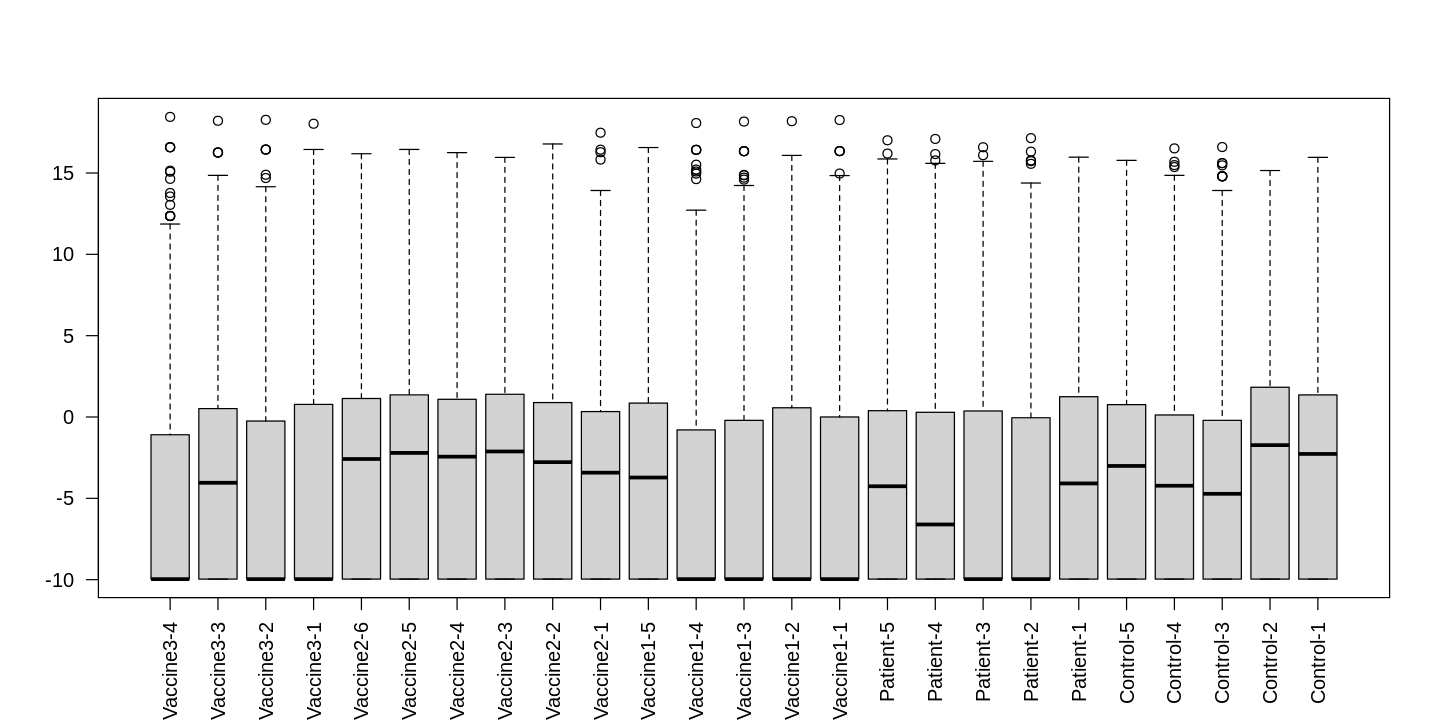

In [12]:
options(repr.plot.width=12, repr.plot.height=6)
boxplot(log(txi$abundance+0.001, base=2), las=2)

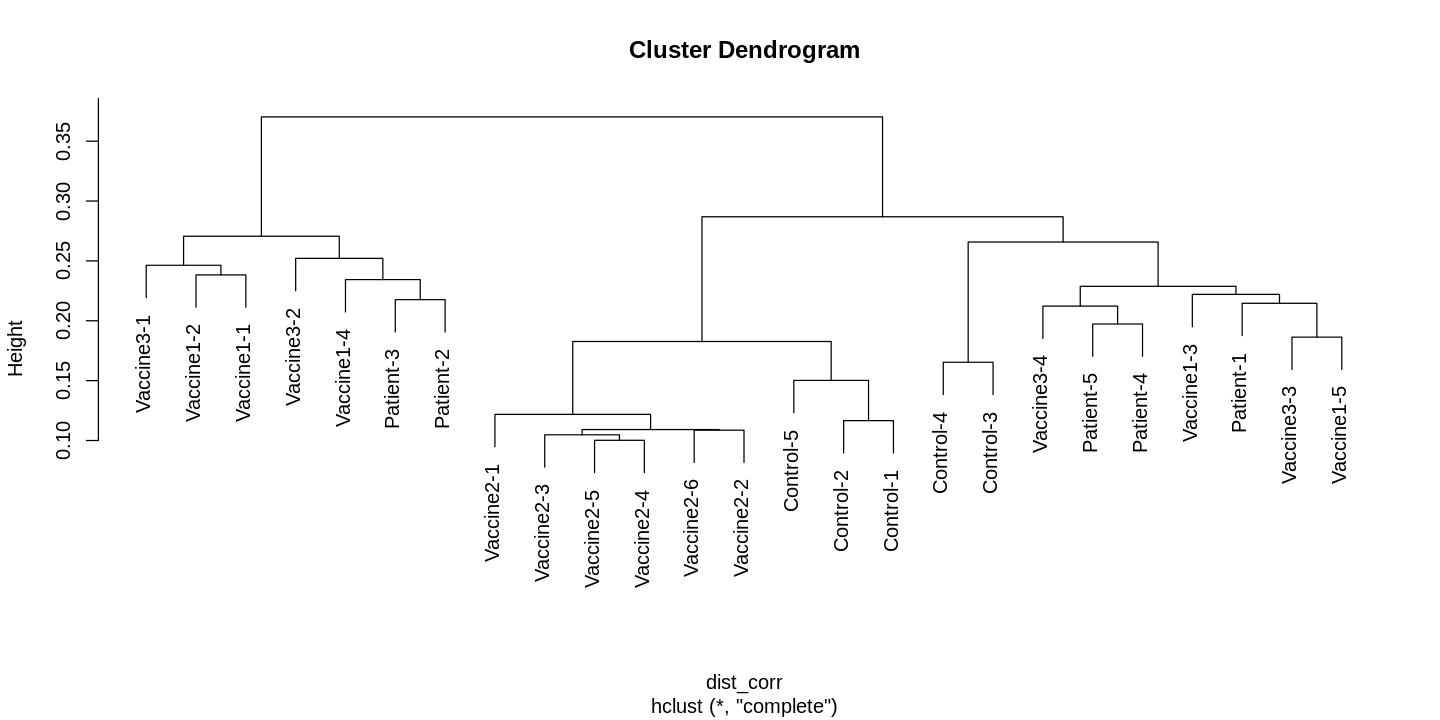

In [13]:
dist_corr <- dist(1-cor(as.matrix(txi$abundance), method='spearman'))
plot(hclust(dist_corr))

## Normalization & fileration of low expressed gene

In [14]:
## Convert tximport object to DEGList 
y <- DGEList(counts=txi$counts, group=samples$GroupName)

## Perform normalization
y <- calcNormFactors(y)

## Check the dimension of the data before low expression filtering
dim(y)
keep <- filterByExpr(y, group=samples$GroupName)
y <- y[keep, , keep.lib.sizes=FALSE]

## Check the dimension of the data after low expression filtering
dim(y)

[1] 60308    25

[1] 27885    25

## Quality check with boxplot & hierarchical clustering AFTER filteration & normalization

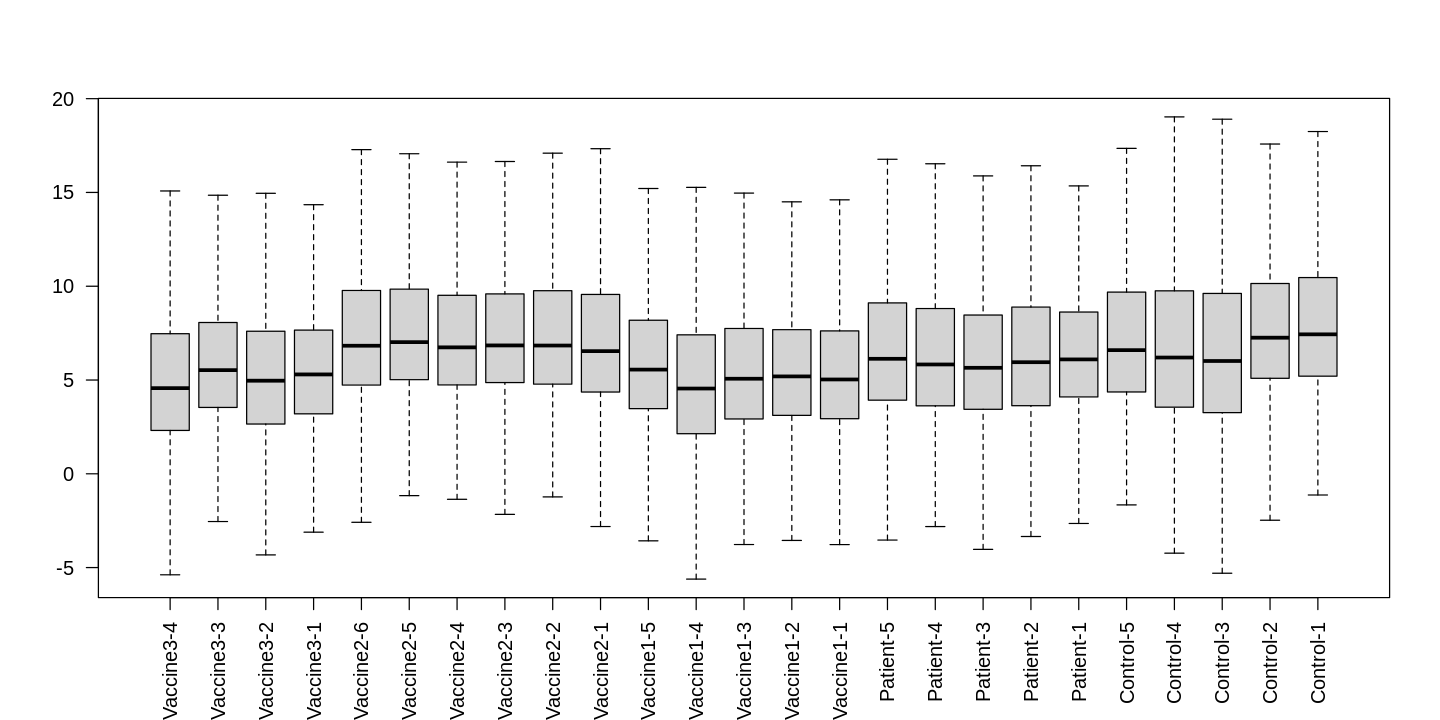

In [15]:
options(repr.plot.width=12, repr.plot.height=6)
boxplot(log(as.matrix(y)+0.001, base=2), las=2, outline=FALSE)

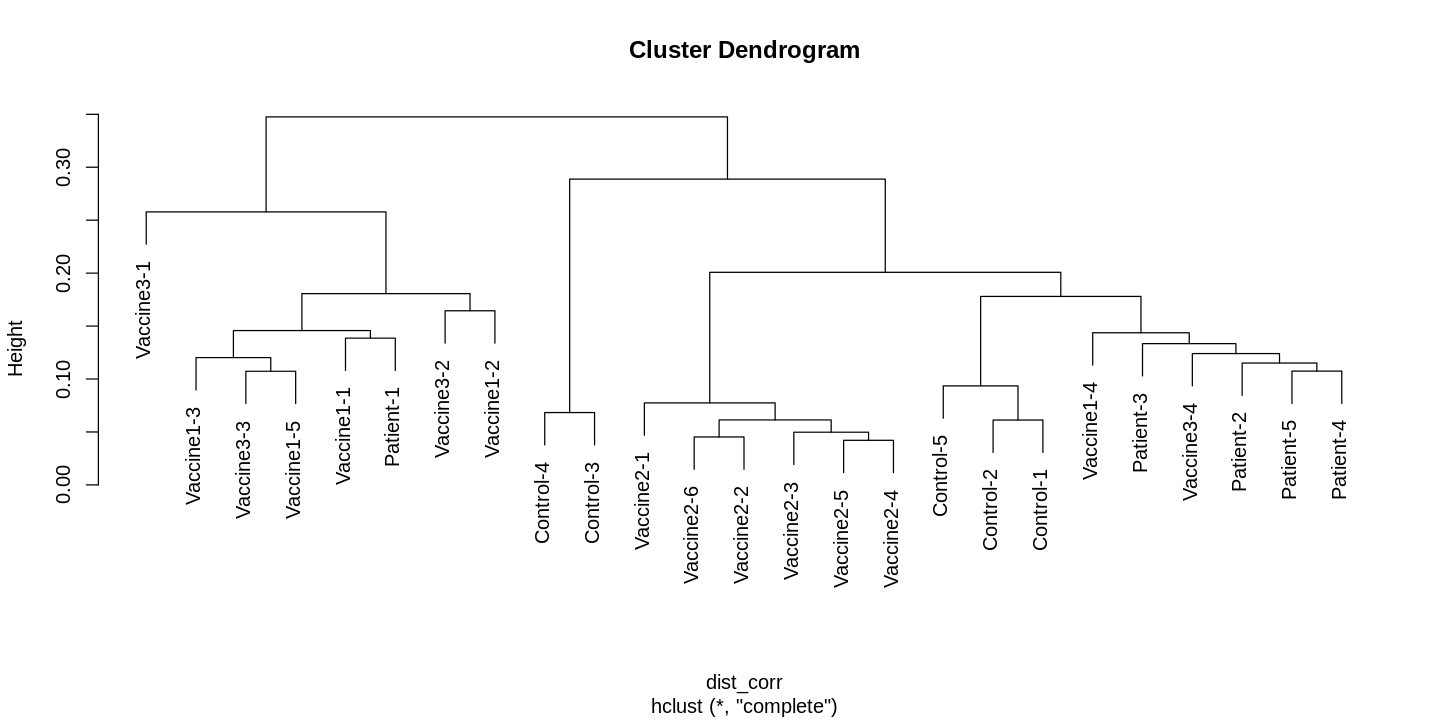

In [16]:
dist_corr <- dist(1-cor(as.matrix(y), method='spearman'))
plot(hclust(dist_corr))

## Differentially expressed gene analysis with linear model

For more information, see "8. Linear Model Overview" and "15. RNA-seq Data" of "the limma user guide" https://www.bioconductor.org/packages/devel/bioc/vignettes/limma/inst/doc/usersguide.pdf

In [20]:
## Make a design matrix. 
groups <- samples$GroupName
design <- model.matrix(~0+groups)
colnames(design) <- gsub('groups', '', colnames(design))
design

,Control,Patient,Vaccine1,Vaccine2,Vaccine3
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1
5,0,0,0,1,0
6,0,0,0,1,0
7,0,0,0,1,0
8,0,0,0,1,0
9,0,0,0,1,0
10,0,0,0,1,0


In [21]:
v <- voom(y, design)
fit_lm <- lmFit(v, design)
contrast_mat <- makeContrasts(Patient-Control, Vaccine2-Control, levels=design)

fit_c <- contrasts.fit(fit_lm, contrast_mat)
fit_c <- eBayes(fit_c)

list_patient <- topTable(fit_c, coef=1, confint=TRUE, n=Inf, adjust="BH")
list_vacc2 <- topTable(fit_c, coef=2, confint=TRUE, n=Inf, adjust="BH")

head(list_patient)
head(list_vacc2)

,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NOCT,2.870218,2.494252,3.246185,4.385650,15.66497,4.579130e-15,1.276890e-10,23.62645
GIMAP8,-2.795197,-3.175617,-2.414776,4.031562,-15.07691,1.160365e-14,1.617840e-10,23.05287
SLC7A5,3.127841,2.665855,3.589827,6.541467,13.89248,8.265510e-14,7.682792e-10,21.46934
RELB,2.404354,2.030886,2.777822,5.611069,13.21018,2.717237e-13,1.894254e-09,20.27476
LDLR,2.325155,1.955255,2.695055,6.822656,12.89825,4.754226e-13,2.651432e-09,19.83515
GABARAPL1,1.989754,1.660425,2.319082,6.442129,12.39749,1.191889e-12,5.491262e-09,18.93690


,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GIMAP8,-3.303941,-3.643868,-2.964014,4.031562,-19.94393,1.124041e-17,3.134388e-13,29.83017
SH2D3C,-1.938040,-2.194440,-1.681640,4.726997,-15.50987,5.835617e-15,4.463090e-11,24.14655
GIMAP4,-3.170917,-3.592000,-2.749835,5.492602,-15.45189,6.392476e-15,4.463090e-11,24.10923
IRF2,-2.001990,-2.267861,-1.736119,5.268619,-15.45093,6.402137e-15,4.463090e-11,24.07053
IL16,-1.777316,-2.026677,-1.527955,6.887450,-14.62515,2.417799e-14,1.006876e-10,22.83358
DUSP8,3.465465,2.982644,3.948286,5.561566,14.72783,2.043034e-14,1.006876e-10,22.79152


# Report the result as a table. 
After running this block, you can see the report files on the left panel. You can download them through your browser. 

In [22]:
## When you have a multiple list for comparison, you can change the following two lines, and repeat this block for multiple DEG report.
total_list <- list_patient
filename_out <- 'Patient-vs-Control'
##

## Condition to call DEG: here we use adj.P.Value < 0.05 and FC > 2
DE_keep <- total_list$adj.P.Val < 0.05 & abs(total_list$logFC) >= 1
DE_list <- total_list[DE_keep,]

## This is the list of all results
filename_all <- paste(filename_out, 'limma_all.txt', sep='.')
write.table(total_list, filename_all, sep='\t')

## This is the list of only-DEG results
filename_DE <- paste(filename_out, 'limma_DE.txt', sep='.')
write.table(DE_list, filename_DE, sep='\t')

## This is the list of CPM results (it would be different to TPM and other values, becuase it is estimated by limma from the counts you provide)
filename_cpm <- paste(filename_out, 'abundance.txt', sep='.')
write.table(txi$abundance, filename_cpm, sep='\t')